In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import uproot
import pandas as pd

import seaborn as sns
# Apply the default theme
sns.set_theme(palette='dark')
#sns.set_style("whitegrid")

from ipywidgets import *
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline


PDG_CODES = {22: 'gamma', 11: 'e', 13: 'mu', 211: 'pi',
              321: 'K', 2212: 'p', 2112: 'n', 
              1000010020: 'deuteron', 1000010030: 'triton', 1000020040: 'alpha', 1000020030: 'He3'}

[57.51991812 26.77660559 69.48386118 ... 51.11656027 64.72002145
 25.05799295]


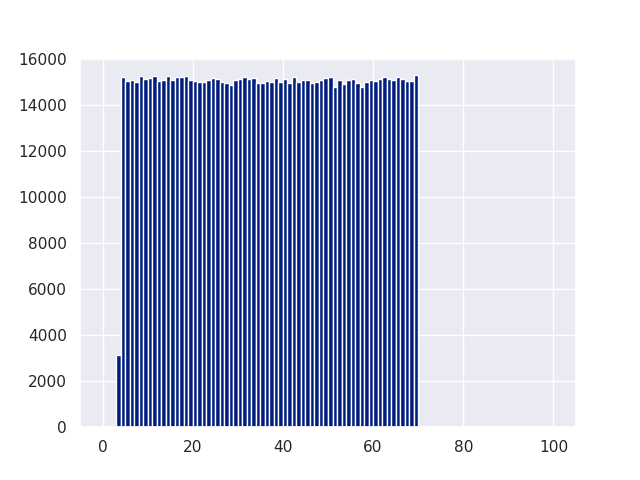

In [2]:
%matplotlib widget
#file_path = "crpa/events45.root"
file_path = "marley-old/flat.root"
# file_path = "marley-old/flat_ES.root"
    
marleydata = uproot.open(file_path)["mst"]
marleyframe = marleydata.arrays(library='pd')
marleyarr = marleydata.arrays(library='np')
marleyarr["pdgp"][0]

for key in marleyarr.keys():
    continue
    print(key)

# Plot the energy distribution
fig, ax = plt.subplots()
ax.hist(marleyarr["Ev"], bins=100, range=(0, 100), label='E')

print(marleyarr["Ev"])



<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'awkward.highlevel.Array'>
3035407
[[22, 2112, 2212, 1000010020, 1000010030, 1000020030, 1000020040], [...]]


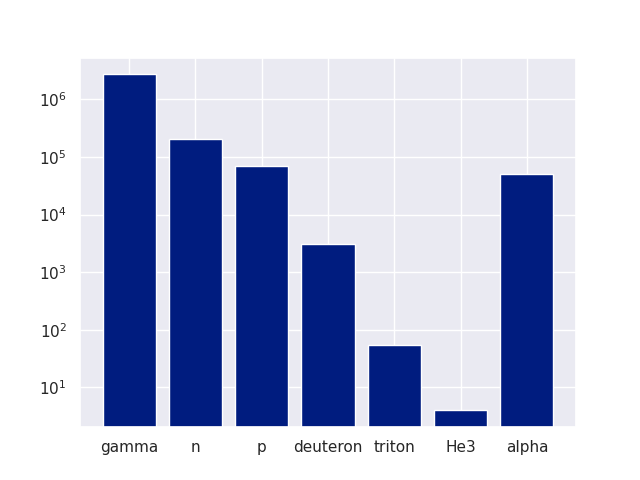

In [3]:
%matplotlib widget
# for i, arr in enumerate(marleyframe["pdgp"]):
#     for j, pdg in enumerate(arr):
#         if pdg > 3000 and pdg != 1000020040:
#             print(pdg, i)

# for el in marleyframe["pdgp"]:
#     print(el)

# for row in marleyframe.loc[:, ['pdgp']].itertuples():
#     print(row)

# marleyframe["pdgp"].value_counts().plot(kind='bar')
# plt.yscale('log')

print(type(marleyframe))
print(type(marleyframe["pdgp"]))

# Count the number of events with a given pdg code, without using the value_counts() method
#marleyframe.pdgp.nunique()
print(type(marleyframe["pdgp"][0]))

# Each entry in marleyframe["pdgp"] is a list of pdg codes for the particles in the event
# Merge all these lists into a single list
pdglist = np.concatenate(marleyframe["pdgp"])
print(len(pdglist))

# Count the number of times each pdg code appears in the list
pdgcounts = np.unique(pdglist, return_counts=True)

print(pdgcounts)

# Plot the number of times each pdg code appears
fig, ax = plt.subplots()
particle_types = [PDG_CODES[pdg] for pdg in pdgcounts[0]]
#ax.bar(pdgcounts[0], pdgcounts[1])
ax.bar(particle_types, pdgcounts[1])
ax.set_yscale('log')
# ax.set_xlabel('PDG code')
# ax.set_ylabel('Number of occurrences')


In [4]:
gamma, proton, neutron, deuteron, triton, alpha, he3 = 0, 0, 0, 0, 0, 0, 0

for i, arr in enumerate(marleyarr["pdgp"]):
    if 22 in arr:
        gamma += 1
    if 2112 in arr:
        neutron += 1
    if 2212 in arr:
        proton += 1
    if 1000010020 in arr:
        deuteron += 1
    if 1000010030 in arr:
        triton += 1
    if 1000020040 in arr:
        alpha += 1
    if 1000020030 in arr:
        he3 += 1

event_num = len(marleyarr["pdgp"])
print(gamma, proton, neutron, deuteron, triton, alpha, he3)
print(gamma/event_num * 100, proton/event_num * 100, neutron/event_num * 100, deuteron/event_num * 100, triton/event_num * 100, alpha/event_num * 100, he3/event_num * 100)

929428 69956 206852 3085 55 49480 4
92.9428 6.9956000000000005 20.685200000000002 0.3085 0.0055000000000000005 4.948 0.00039999999999999996


[ 40.09996036  30.91557048 123.54292937 ...  65.05680358  48.99808991
  11.53511148]
[51.60982883 10.78308234 63.26604271 ... 37.96210162 58.67496507
 19.16771507]


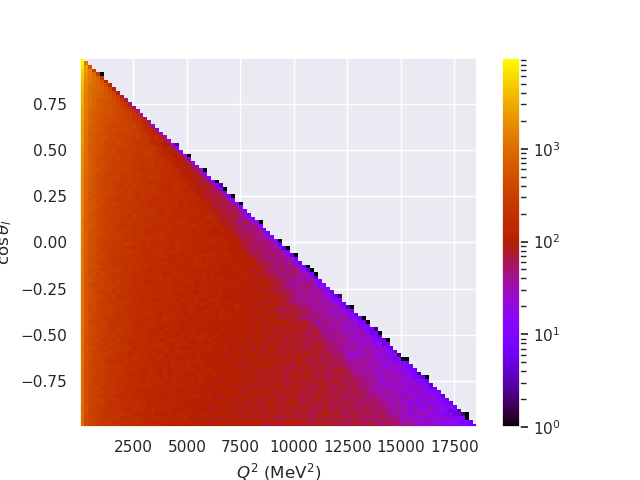

In [5]:
%matplotlib widget
mod_pl = np.sqrt(marleyarr["pxl"]**2 + marleyarr["pyl"]**2 + marleyarr["pzl"]**2)
cos_thetal = marleyarr["pzl"]/mod_pl

# Momentum transfer
q_sq = (marleyarr["El"] - marleyarr["Ev"])**2 - ((marleyarr["pxl"] - marleyarr["pxv"])**2 + (marleyarr["pyl"] - marleyarr["pyv"])**2 + (marleyarr["pzl"] - marleyarr["pzv"])**2)
kinectic_l = marleyarr["KEl"]

q0 = marleyarr["El"] - marleyarr["Ev"]
q3 = marleyarr["pzl"] - marleyarr["pzv"]

plt.figure()
plt.hist2d(-q_sq, cos_thetal, bins=100, density=False, norm=mpl.colors.LogNorm(), cmap='gnuplot');
plt.xlabel(r'$Q^2$ (MeV$^2$)')
plt.ylabel(r'$\cos{\theta_l}$')
plt.colorbar()

print(np.sqrt(-q_sq))
print(kinectic_l)

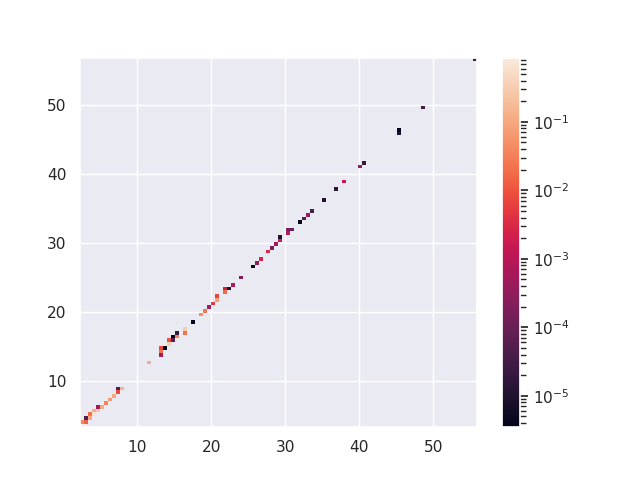

In [6]:
plt.figure()
plt.hist2d(marleyarr["Ex"], -q0, bins=100, density=True, norm=mpl.colors.LogNorm());
plt.colorbar()

# plt.figure()
# plt.scatter(-q3, -q0, s=0.1)

## Cross section stuff

In [7]:
%matplotlib widget
cut = 10
q0_cont = q0[q0 < -cut]
prop = len(q0_cont) / len(q0)

print("MARLEY flux-averaged cross section:", marleyarr["xsec"][0])
print("MARLEY flux-averaged cross section above {} MeV: {} ".format(cut, marleyarr["xsec"][0] * prop))

print("Proportion:", prop)

unique_e = np.unique(np.round(marleyarr["Ex"], 4))
print(unique_e)

%matplotlib widget
flux_averaged = marleyarr["xsec"][0]
_, mbins = np.histogram(-q0, bins=100)
bin_width = np.diff(mbins)[0]

weights = flux_averaged / event_num * 1/bin_width * np.ones(event_num);
# plt.figure(1)
# my, _, _ = plt.hist(-q0, bins=mbins, weights=weights);
my, _ = np.histogram(-q0, bins=mbins, weights=weights)
#plt.yscale('log')

# -------------------------------------------------
# file_path = "~/Downloads/omega100k.root"
# # crpadata = ROOT.TFile.Open(file_path)
# # h = crpadata.Canvas_1.GetListOfPrimitives().At(1)
# # bins = np.linspace(h.GetXaxis().GetXmin(), h.GetXaxis().GetXmax()-h.GetXaxis().GetBinWidth(1), num=h.GetNbinsX())
# # yvals = np.array(h)[1:-1] * 40 # 40 nucleons in the atom
# # print("CRPA flux-averaged cross section: ", np.sum(yvals * h.GetXaxis().GetBinWidth(1)))
# crpadata = uproot.open(file_path)
# h = crpadata["clonedHistogram"]
# yvals = h.values()
# bins = h.axis().edges()[:-1]

# print(len(yvals), len(bins))

# print("CRPA flux-averaged cross section: ", np.sum(yvals * h.axis().widths()))

# plt.figure()
# #plt.plot(mbins[:-1], my[:])
# plt.hist(-q0, bins=mbins, weights=weights)
# plt.bar(bins, yvals, width=0.3, color='red')

# plt.figure()
# plt.hist(-q0, bins=mbins, weights=weights, label="MARLEY")
# plt.plot(bins, yvals, color='red', label="CRPA")
# plt.xlim(left=0, right=30)
# plt.ylim(top=20)
# plt.xlabel(r'$-q_0$ (MeV)')
# plt.ylabel(r'x-section ($10^{-42}$ cm$^{2}$ MeV$^{-1}$)')
# plt.legend()

MARLEY flux-averaged cross section: 0.0
MARLEY flux-averaged cross section above 10 MeV: 0.0 
Proportion: 0.28488
[ 2.2899  2.7304  3.1465  3.517   3.8403  4.3837  4.508   4.765   5.1899
  5.681   6.118   6.79    7.468   7.795   7.952  11.5911 13.0166 13.5103
 13.6599 14.31   14.3429 14.3682 14.4731 14.9868 15.3491 15.5106 16.2332
 17.4329 18.4256 18.4747 19.0242 19.3183 19.5646 20.0164 20.3201 20.9457
 21.8726 21.953  22.0766 22.3862 22.6744 22.7197 22.9145 23.8849 24.1001
 25.5522 26.0876 26.4701 26.6057 26.8406 27.7207 28.0448 28.2149 28.5759
 29.1683 29.511  30.4662 30.633  30.7998 31.8595 32.6531 33.0752 33.1324
 33.1968 33.7699 35.021  35.4911 36.6169 37.9736 39.9096 40.4561 45.1571
 48.6961 55.8583]


Text(0.5, 0, '$\\cos{\\theta_l}$')

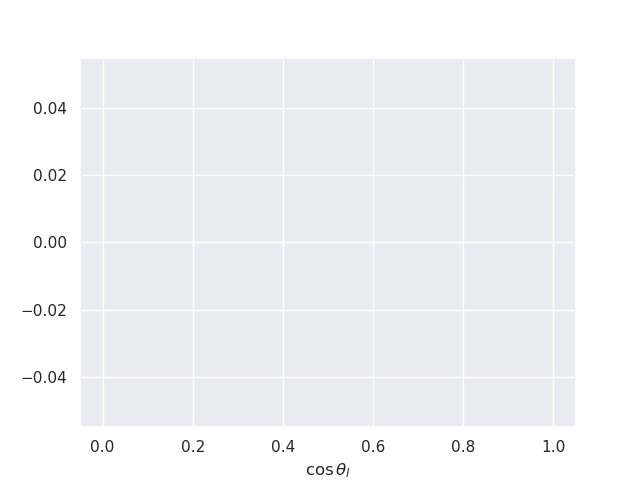

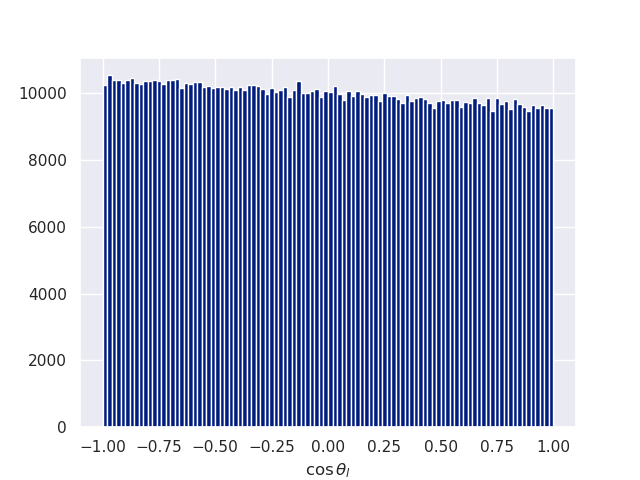

In [13]:
cut = 0
plt.figure()
plt.hist(cos_thetal[-q0 < cut], bins=100);
plt.xlabel(r'$\cos{\theta_l}$')
plt.figure()
plt.hist(cos_thetal[-q0 > cut], bins=100);
plt.xlabel(r'$\cos{\theta_l}$')

# -------------------------------------------------
# event_num = len(marleyarr["Ex"])
# new_event_num = len(cos_thetal[-q0 > cut])
# print(event_num)
# flux_averaged = marleyarr["xsec"][0]
# _, mbins = np.histogram(cos_thetal[-q0 > cut], bins=100)
# bin_width = np.diff(mbins)[0]

# weights = flux_averaged / event_num * 1/bin_width * np.ones(new_event_num);
# # plt.figure(1)
# # my, _, _ = plt.hist(-q0, bins=mbins, weights=weights);
# my, _ = np.histogram(cos_thetal[-q0 > cut], bins=mbins, weights=weights)

# # -------------------------------------------------
# file_path = "~/Downloads/cosLep100k.root"
# crpadata = ROOT.TFile.Open(file_path)
# h = crpadata.Canvas_1.GetListOfPrimitives().At(1)
# bins = np.linspace(h.GetXaxis().GetXmin(), h.GetXaxis().GetXmax()-h.GetXaxis().GetBinWidth(1), num=h.GetNbinsX())
# yvals = np.array(h)[1:-1] * 40 # 40 nucleons in the atom
# # --------------------------------------------------

# plt.figure()
# plt.hist(cos_thetal[-q0 > cut], bins=mbins, weights=weights);
# plt.plot(bins, yvals, color='red');

# plt.xlabel(r'$\cos{\theta_l}$')
# plt.ylabel(r'x-section ($10^{-42}$ cm$^{2}$ Mev$^{-1}$)');

In [9]:
ar0_abs = -35039.9000
k0_abs = -33535.50

k0 = 0
k1 = 29.8299
k2 = 800.1431
k3 = 891.394
k4 = 1643.638
k5 = 1959.071

delta = k0_abs - ar0_abs

cl0_abs = -27560

delta_cl = cl0_abs - ar0_abs

delta + k2

2304.5431000000017

## Fluxes from snowglobes and else

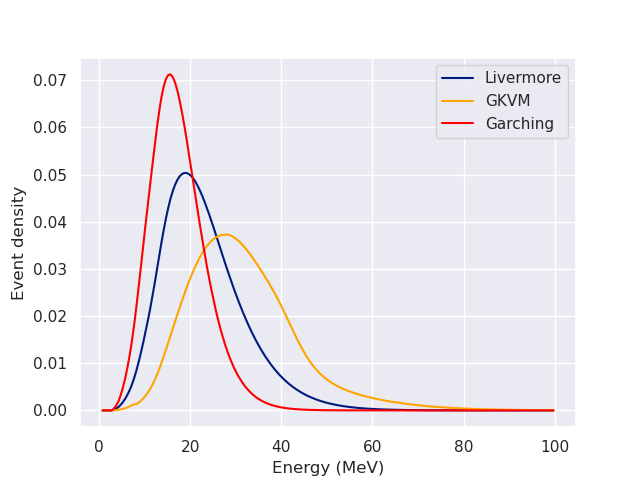

In [10]:
%matplotlib widget

# mode = "ES" # "ES" or "CC"
mode = "CC" # "ES" or "CC"

#snowglobes_path = "/Users/pbarham/OneDrive/workspace/snowglobes/out/"
snowglobes_path = "interacted-fluxes/"

if mode == "CC":
    sg_livermore = "livermore_nue_Ar40_ar40kt_events.dat"
    sg_gvkm = "gvkm_nue_Ar40_ar40kt_events.dat"
    sg_pinched = "pinched_0_paperoriginal_nue_Ar40_ar40kt_events.dat"

    sg_livermore_data = np.genfromtxt(snowglobes_path + sg_livermore, skip_footer=2)
    sg_gvkm_data = np.genfromtxt(snowglobes_path + sg_gvkm, delimiter=' ', skip_footer=2)
    sg_pinched_data = np.genfromtxt(snowglobes_path + sg_pinched, delimiter=' ', skip_footer=2)

    sg_livermore_energies = sg_livermore_data[:, 0] * 1000
    sg_livermore_spectrum = sg_livermore_data[:, 1] 
    sg_livermore_norm = np.sum(sg_livermore_spectrum) * np.diff(sg_livermore_energies)[0]

    sg_gvkm_energies = sg_gvkm_data[:, 0] * 1000
    sg_gvkm_spectrum = sg_gvkm_data[:, 1] 
    sg_gkvm_norm = np.sum(sg_gvkm_spectrum) * np.diff(sg_gvkm_energies)[0]

    sg_pinched_energies = sg_pinched_data[:, 0] * 1000
    sg_pinched_spectrum = sg_pinched_data[:, 1]
    sg_pinched_norm = np.sum(sg_pinched_spectrum) * np.diff(sg_pinched_energies)[0]

elif mode == "ES":
    neutrino_types = ["nue", "numu", "nutau", "nuebar", "numubar", "nutaubar"]
    sg_livermore = ["livermore_{}_e_ar40kt_events.dat".format(nu) for nu in neutrino_types]
    sg_gvkm = ["gvkm_{}_e_ar40kt_events.dat".format(nu) for nu in neutrino_types]
    sg_pinched = ["pinched_0_paperoriginal_{}_e_ar40kt_events.dat".format(nu) for nu in neutrino_types]

    sg_livermore_data = [np.genfromtxt(snowglobes_path + s, skip_footer=2) for s in sg_livermore]
    sg_gvkm_data = [np.genfromtxt(snowglobes_path + s, delimiter=' ', skip_footer=2) for s in sg_gvkm]
    sg_pinched_data = [np.genfromtxt(snowglobes_path + s, delimiter=' ', skip_footer=2) for s in sg_pinched]

    sg_livermore_energies = sg_livermore_data[0][:, 0] * 1000
    sg_livermore_spectrum = np.sum([s[:, 1] for s in sg_livermore_data], axis=0)
    sg_livermore_norm = np.sum(sg_livermore_spectrum) * np.diff(sg_livermore_energies)[0]

    sg_gvkm_energies = sg_gvkm_data[0][:, 0] * 1000
    sg_gvkm_spectrum = np.sum([s[:, 1] for s in sg_gvkm_data], axis=0)
    sg_gkvm_norm = np.sum(sg_gvkm_spectrum) * np.diff(sg_gvkm_energies)[0]

    sg_pinched_energies = sg_pinched_data[0][:, 0] * 1000
    sg_pinched_spectrum = np.sum([s[:, 1] for s in sg_pinched_data], axis=0)
    sg_pinched_norm = np.sum(sg_pinched_spectrum) * np.diff(sg_pinched_energies)[0]


plt.figure()
plt.plot(sg_livermore_energies, sg_livermore_spectrum/sg_livermore_norm, label="Livermore")
plt.plot(sg_gvkm_energies, sg_gvkm_spectrum/sg_gkvm_norm, label="GKVM", c='orange')
plt.plot(sg_pinched_energies, sg_pinched_spectrum/sg_pinched_norm, c='red', label="Garching")

#plt.hist(marleyarr["Ev"], bins=100, density=True, color='green', alpha=0.5, label="Livermore MARLEY");
plt.xlabel('Energy (MeV)')
plt.ylabel('Event density')
plt.legend()

# What percentage of these interacted fluxes is above 10 MeV?
# sg_livermore_above_10 = np.sum(sg_livermore_spectrum[sg_livermore_energies > 10]) / sg_livermore_norm * np.diff(sg_livermore_energies)[0]
# sg_gvkm_above_10 = np.sum(sg_gvkm_spectrum[sg_gvkm_energies > 10]) / sg_gkvm_norm * np.diff(sg_gvkm_energies)[0]
# sg_pinched_above_10 = np.sum(sg_pinched_spectrum[sg_pinched_energies > 10]) / sg_pinched_norm * np.diff(sg_pinched_energies)[0]

# print(sg_livermore_above_10, sg_gvkm_above_10, sg_pinched_above_10)

# Plot all GKVM fluxes
if mode == "ES":
    plt.figure()
    for s in sg_gvkm_data:
        plt.plot(s[:, 0] * 1000, s[:, 1])

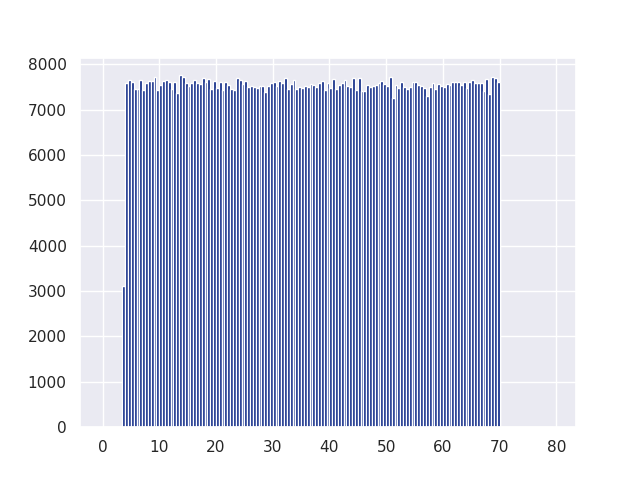

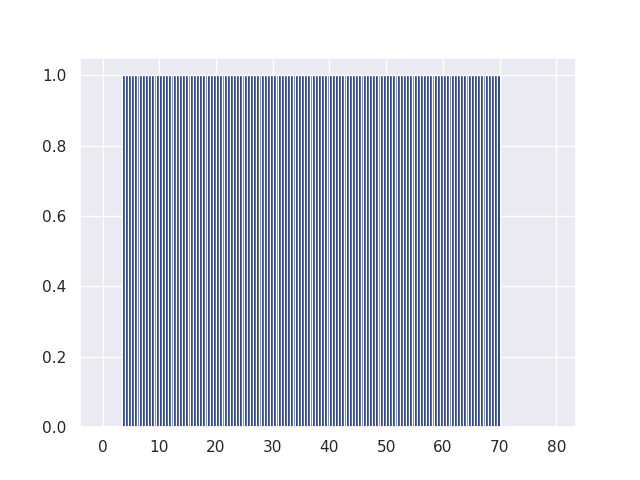

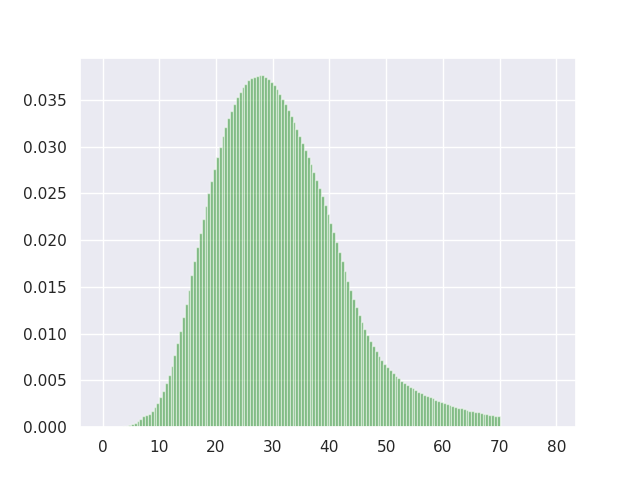

In [11]:
%matplotlib widget
# For a flat spectrum of energies, let's weigh the events by a given interacted flux
bins = np.arange(0, 80, 0.5)
fig, ax = plt.subplots()
h, _, _ = ax.hist(marleyarr["Ev"], bins=bins, label='E')

# Step 0: as we know the spectrum should be identically flat, let's weigh the events by their (inverse) bin size (a 0.5 MeV bin size should work)
weights_mc = np.zeros_like(marleyarr["Ev"])
for i in range(len(h)):
    # Get the events in the bin
    bin_events = marleyarr["Ev"][(marleyarr["Ev"] > bins[i]) & (marleyarr["Ev"] < bins[i+1])]
    if bin_events.size == 0:
        continue
    # Weigh the events by the inverse bin size
    weights_mc[(marleyarr["Ev"] > bins[i]) & (marleyarr["Ev"] < bins[i+1])] = 1/len(bin_events)

fig, ax = plt.subplots()
ax.hist(marleyarr["Ev"], bins=bins, weights=weights_mc, label='E')

# Now, let's weigh the events by the interacted flux
# Step 1: Interpolate the flux so we can get the value of the flux at the energy of each event
spl = CubicSpline(sg_gvkm_energies, sg_gvkm_spectrum/sg_gkvm_norm)
weights = spl(marleyarr["Ev"]) * weights_mc

# Step 2: As the flat energy range doesn't cover the full flux (and we have the weights_mc term), normalise the weights so the add up to 1
weights = weights / np.sum(weights)

# Step 3: Weigh the events by the flux, plot the histogram
plt.figure()
plt.hist(marleyarr["Ev"], bins=bins, weights=weights, density=True, color='green', alpha=0.5, label="GKVM MARLEY");


Text(0, 0.5, '$\\cos{\\theta_l}$')

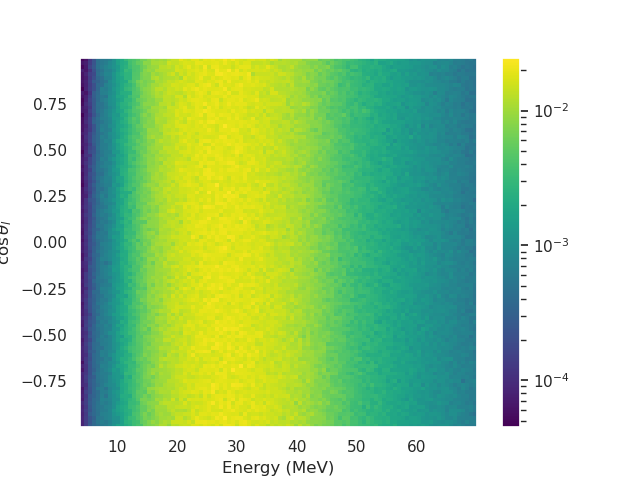

In [12]:
# Some histograms

fig, ax = plt.subplots()
h = ax.hist2d(marleyarr["Ev"], cos_thetal, bins=100, density=True, weights=weights, cmap='viridis', norm=mpl.colors.LogNorm());
cbar = plt.colorbar(h[3], ax=ax)

ax.set_xlabel('Energy (MeV)')
ax.set_ylabel(r'$\cos{\theta_l}$')